### INICIO PROYECTO 

Transformaciones y limpiezas, incluyendo el _feature engineering_, así como visualizaciones dentro de un análisis exploratiorio.

In [20]:
import pandas as pd
import os
import numpy as np
import kmodes as km
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [21]:
print(os.getcwd())

c:\Users\aisat\Desktop\DSPT25_RA\3-DSPT2025-ML\Proyecto final\RA_proyecto_final_ML\1.notebooks


In [22]:
# 1. Cargamos el DataFrame con datos mixtos y faltantes.
df_relleno = pd.read_csv ("df_relleno.csv", sep=",")
df_relleno.head()

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0


In [23]:
df_relleno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Complaint ID        28156 non-null  int64 
 1   Product             28156 non-null  object
 2   Sub-product         28156 non-null  object
 3   Issue               28156 non-null  object
 4   Sub-issue           28156 non-null  object
 5   State               28156 non-null  object
 6   ZIP code            28156 non-null  int64 
 7   Company             28156 non-null  object
 8   Company response    28156 non-null  object
 9   Timely response?    28156 non-null  object
 10  Consumer disputed?  28156 non-null  object
 11  Delay Time          28156 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 2.6+ MB


In [24]:
print(df_relleno.isnull().sum())

Complaint ID          0
Product               0
Sub-product           0
Issue                 0
Sub-issue             0
State                 0
ZIP code              0
Company               0
Company response      0
Timely response?      0
Consumer disputed?    0
Delay Time            0
dtype: int64


In [25]:
# Identificar columnas numéricas y categóricas
numerical_cols = df_relleno.select_dtypes(include=['number'])
categorical_cols = df_relleno.select_dtypes(exclude=['number'])

In [26]:
numerical_cols

,Complaint ID,ZIP code,Delay Time
0,1291006,76119,0
1,1290580,77479,0
2,1290564,2127,0
3,1291615,92592,0
4,1292165,43068,0
...,...,...,...
28151,1178184,75201,1
28152,1178183,30043,6
28153,1178182,55105,1
28154,1178181,92509,6


In [27]:
categorical_cols

,Product,Sub-product,Issue,Sub-issue,State,Company,Company response,Timely response?,Consumer disputed?
0,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,"Premium Asset Services, LLC",In progress,Yes,Sin datos
1,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos
2,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,RBS Citizens,Closed with explanation,Yes,Yes
3,Credit card,Sin datos,Other,Sin datos,CA,Navy FCU,In progress,Yes,Sin datos
4,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,Transworld Systems Inc.,In progress,Yes,Sin datos
...,...,...,...,...,...,...,...,...,...
28151,Debt collection,Sin datos,Cont'd attempts collect debt not owed,Debt is not mine,TX,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No
28152,Consumer loan,Vehicle loan,Taking out the loan or lease,Sin datos,GA,DriveTime,Closed with explanation,Yes,Sin datos
28153,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Sin datos,MN,Regions,Closed with non-monetary relief,Yes,No
28154,Payday loan,Sin datos,Can't stop charges to bank account,Sin datos,CA,Moneytree Inc,Closed with explanation,Yes,Sin datos


In [28]:
# Crear una copia para la imputación
df_imputed = df_relleno.copy()

In [29]:
# Para que el algoritmo de clustering funcione se deben imputar temporalmente los NaN.
"""
for col in numerical_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
for col in categorical_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
"""

'\nfor col in numerical_cols:\n    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())\nfor col in categorical_cols:\n    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])\n'

In [30]:
df_imputed.head()

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0


In [31]:
# Identificar columnas numéricas y categóricas
numerical_cols = df_imputed.select_dtypes(include=[np.number])
categorical_cols = df_imputed.select_dtypes(exclude=[np.number])

In [32]:
numerical_cols

,Complaint ID,ZIP code,Delay Time
0,1291006,76119,0
1,1290580,77479,0
2,1290564,2127,0
3,1291615,92592,0
4,1292165,43068,0
...,...,...,...
28151,1178184,75201,1
28152,1178183,30043,6
28153,1178182,55105,1
28154,1178181,92509,6


In [33]:
# 3. Escalar las variables numéricas para el clustering
scaler = StandardScaler()
scaler.fit_transform(numerical_cols)

array([[ 2.31865285,  0.85242692, -0.54363569],
       [ 2.30362757,  0.89670301, -0.54363569],
       [ 2.30306324, -1.55645322, -0.54363569],
       ...,
       [-1.66071909,  0.1682961 , -0.35994466],
       [-1.66075436,  1.386019  ,  0.55851052],
       [-1.66078963, -0.15846801, -0.35994466]])

In [34]:
# 4. Encontrar el K óptimo con el Método del Codo para K-Prototypes
costo_inercia = []
num_clusters = range(1, 11)
cat_indices = [df_imputed.columns.get_loc(col) for col in categorical_cols]

for k in num_clusters:
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5, random_state=42, n_jobs=-1)
        kproto.fit_predict(df_imputed.values, categorical=cat_indices)
        costo_inercia.append(kproto.cost_)
    except Exception as e:
        print(f"Error para K={k}: {e}")

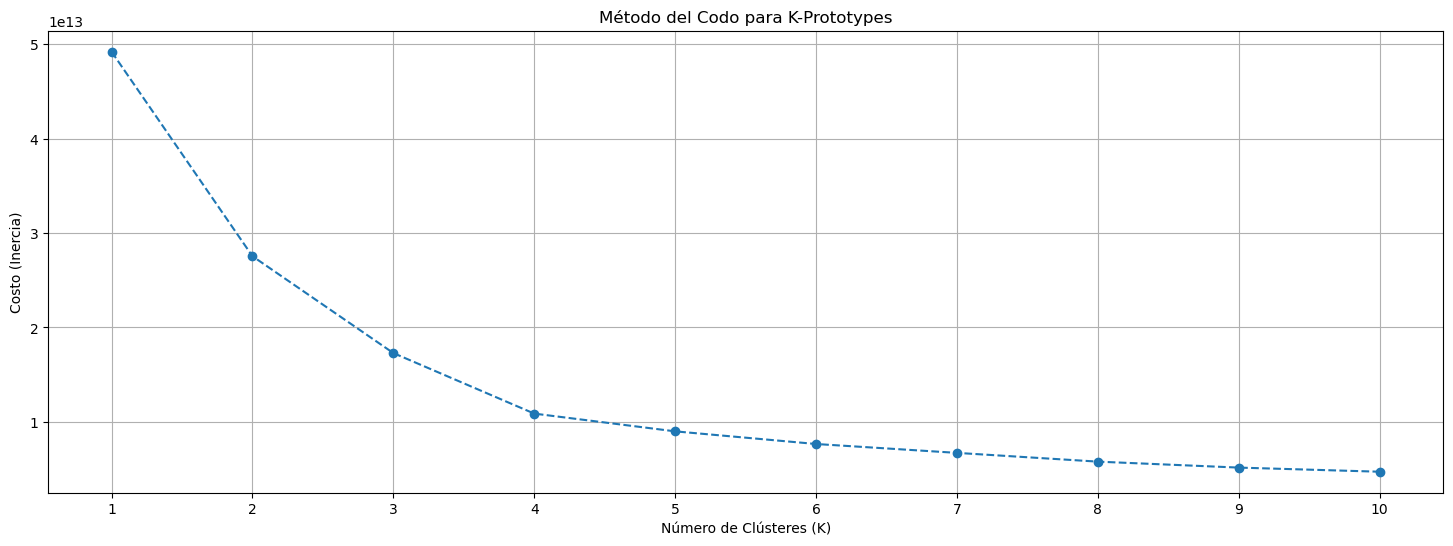

In [35]:
# Gráfico del Método del Codo
plt.figure(figsize=(18, 6))
plt.plot(num_clusters, costo_inercia, marker='o', linestyle='--')
plt.title('Método del Codo para K-Prototypes')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Costo (Inercia)')
plt.xticks(num_clusters)
plt.grid(True)
plt.show()

In [36]:
# Se elige el K óptimo entre 4 y 8 (suponemos que el codo está en K=6)
optimal_k = 6

In [37]:
# 5. Aplicar Clustering K-Prototypes con el K óptimo
kproto = KPrototypes(n_clusters=optimal_k, init='Cao', n_init=5, random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(df_imputed.values, categorical=cat_indices)
df_imputed['cluster'] = clusters

print(f"\nDataFrame con {optimal_k} clústeres:")
df_imputed


DataFrame con 6 clústeres:


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time,cluster
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0,3
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0,3
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0,3
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,1178184,Debt collection,Sin datos,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1,2
28152,1178183,Consumer loan,Vehicle loan,Taking out the loan or lease,Sin datos,GA,30043,DriveTime,Closed with explanation,Yes,Sin datos,6,5
28153,1178182,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Sin datos,MN,55105,Regions,Closed with non-monetary relief,Yes,No,1,2
28154,1178181,Payday loan,Sin datos,Can't stop charges to bank account,Sin datos,CA,92509,Moneytree Inc,Closed with explanation,Yes,Sin datos,6,2


In [38]:
# 6. Imputación final por clúster
# Ahora imputamos los valores del DataFrame original (df)
df_final = df_imputed.copy()

for col in numerical_cols:
    df_final[col] = df_final.groupby(clusters)[col].transform(lambda x: x.fillna(x.median()))

for col in categorical_cols:
    df_final[col] = df_final.groupby(clusters)[col].transform(lambda x: x.fillna(x.mode()[0]))

print("\nVerificación de nulos en el DataFrame final:")
print(df_final.isnull().sum())

print("\nDataFrame Final sin datos faltantes (imputación por clúster):")
df_final


Verificación de nulos en el DataFrame final:
Complaint ID          0
Product               0
Sub-product           0
Issue                 0
Sub-issue             0
State                 0
ZIP code              0
Company               0
Company response      0
Timely response?      0
Consumer disputed?    0
Delay Time            0
cluster               0
dtype: int64

DataFrame Final sin datos faltantes (imputación por clúster):


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time,cluster
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0,3
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0,3
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0,3
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,1178184,Debt collection,Sin datos,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1,2
28152,1178183,Consumer loan,Vehicle loan,Taking out the loan or lease,Sin datos,GA,30043,DriveTime,Closed with explanation,Yes,Sin datos,6,5
28153,1178182,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Sin datos,MN,55105,Regions,Closed with non-monetary relief,Yes,No,1,2
28154,1178181,Payday loan,Sin datos,Can't stop charges to bank account,Sin datos,CA,92509,Moneytree Inc,Closed with explanation,Yes,Sin datos,6,2


In [39]:
df_final_cluster = df_final.groupby("cluster")
df_final_cluster_conteo = df_final.groupby("cluster").count()

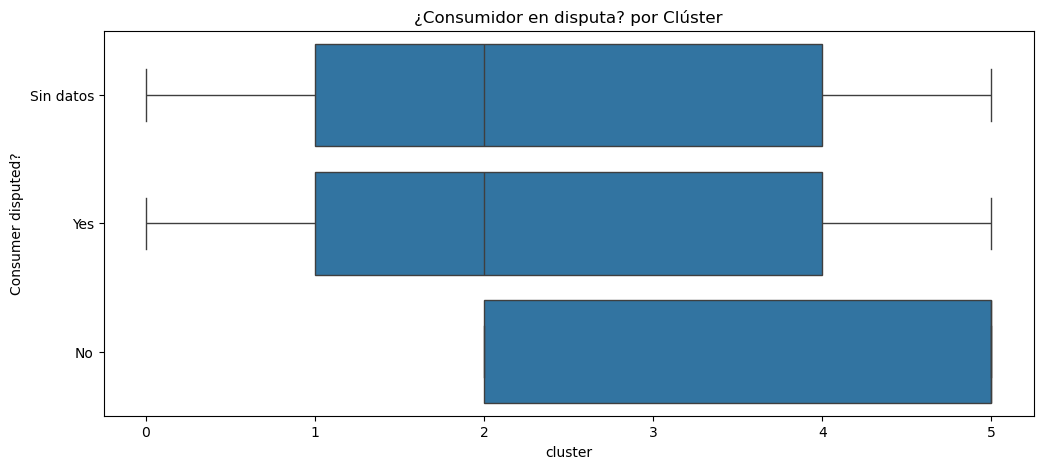

In [40]:
# 7. Análisis y evaluación de los clústeres
# Se puede visualizar la distribución de las variables por clúster
plt.figure(figsize=(12, 5))
sns.boxplot(x='cluster', y='Consumer disputed?', data=df_final)
plt.title('¿Consumidor en disputa? por Clúster')
plt.show()

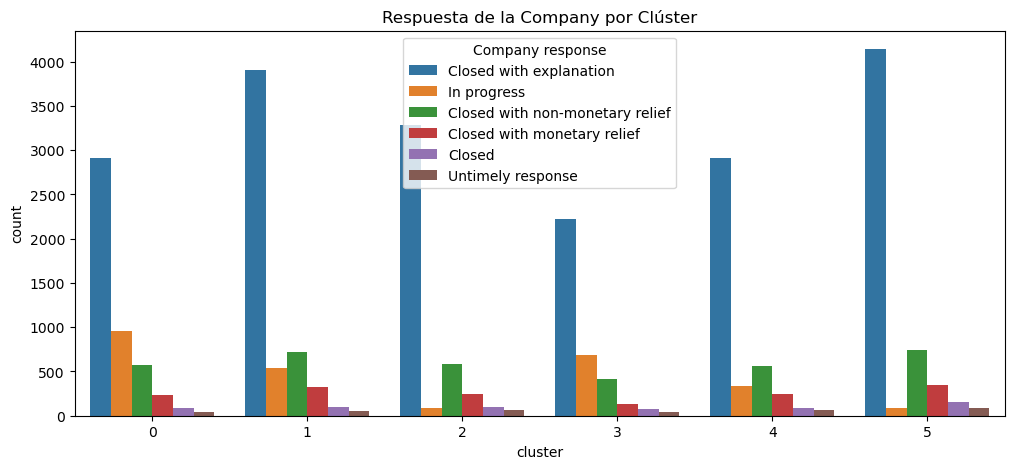

In [41]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Company response', data=df_final)
plt.title('Respuesta de la Company por Clúster')
plt.show()

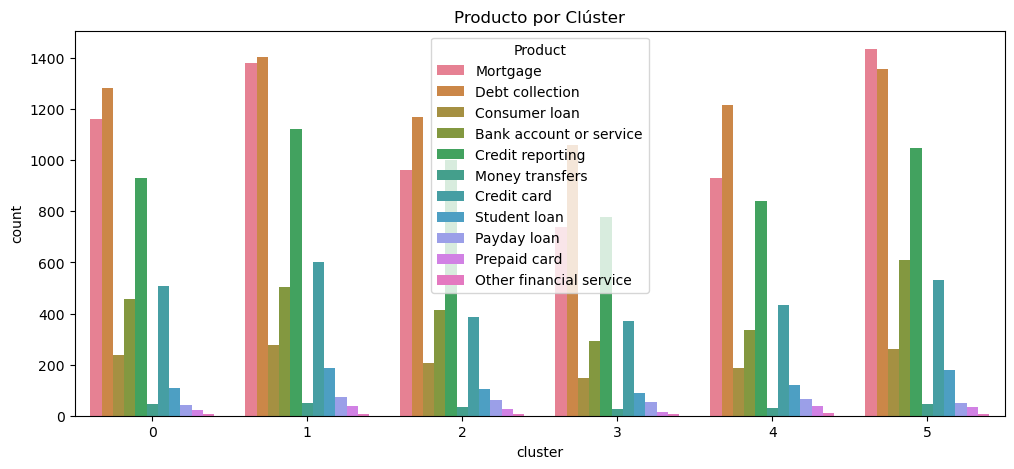

In [42]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Product', data=df_final)
plt.title('Producto por Clúster')
plt.show()

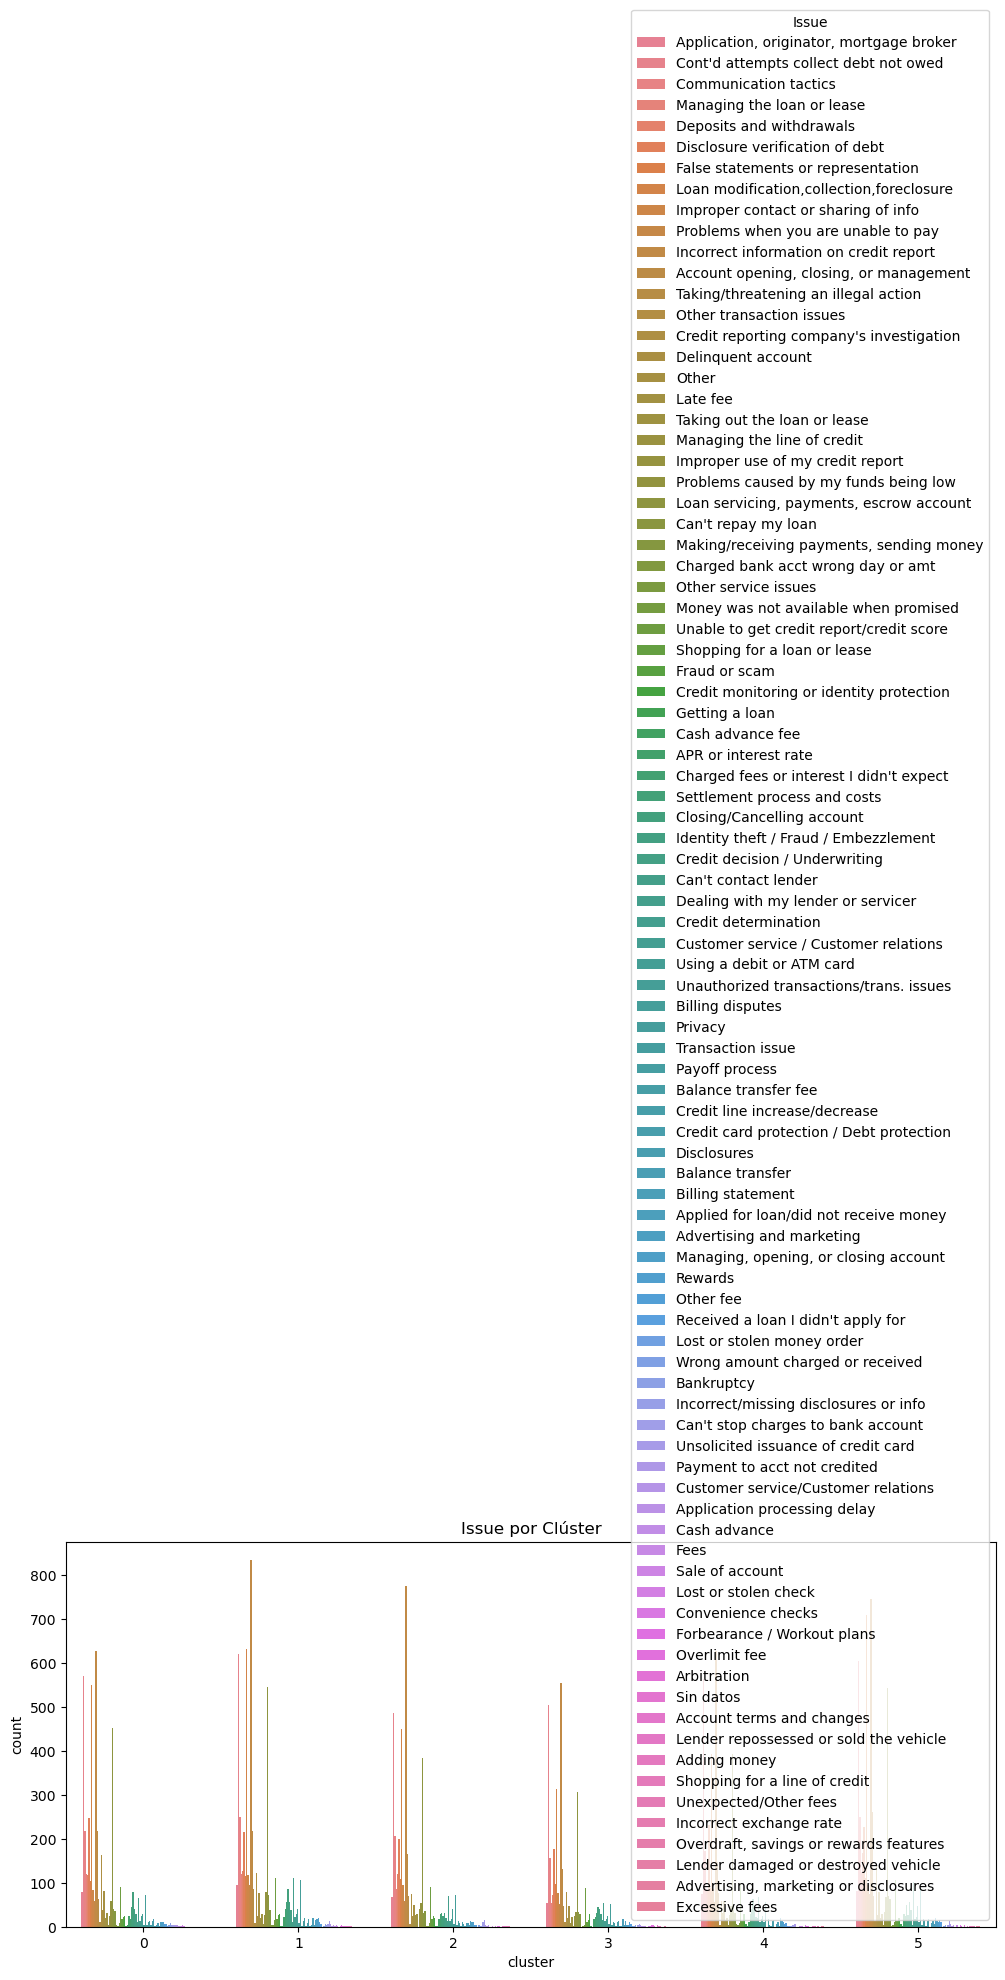

In [43]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Issue', data=df_final)
plt.title('Issue por Clúster')
plt.show()